# Define misc functions

In [1]:
from numba import jit, cuda
import pickle
import os
from numba import jit, cuda
def serialize(file,location):
  with open(location, 'wb') as fp:
    pickle.dump(file, fp)

def log_progress(file,location):
  with open(location, "w") as f:
      for s in file:
          f.write(str(s) +"\n")

def log_summerize(file,location):
  with open(location, "w") as f:
    f.write(str(file))

def read_file(location):
  temp = None
  with open (location, 'rb') as fp:
      temp = pickle.load(fp)
  return temp

# Define objetive functions

In [2]:
import math
def Sphere_f(x):
    sum = 0
    for i in x:
        sum += i**2
    
    return sum

def Rosenbrock_f(x):
    sum = 0
    for i in range(len(x) - 1):
        sum += (100*((x[i + 1] - x[i]**2)**2) + (1 -x[i])**2)
    return sum

def Ackley_f(x):
    a = 20
    b = 0.2
    c = 2 * np.pi
    f1 = 0
    f2 = 0
    for i in range(len(x)):
        f1 += x[i] ** 2
        f2 += np.cos(c * x[i])
    p1 = -a * np.exp(-b * np.sqrt(f1 / len(x)))
    p2 = -np.exp(f2 / len(x))

    return p1 + p2 + a + np.exp(1)

def Zakharov_f(x):
    sum1=0
    sum2=0
    for i in range(len(x)):
        sum1 = sum1 + x[i] **2
        sum2 = sum2 + 0.5*i*x[i]
    return sum1 + sum2**2 + sum2**4;

def Michalewicz_f(x):
    m=10
    sum=0
    for i in range(len(x)):
        new = np.sin(x[i])*(np.sin(i*x[i]**2)) **(2*m)
        sum = sum + new
    return -sum

# Define DE 

In [ ]:
import numpy as np
import random
def DE(fobj, dimension, bounds, F_scale, cross_prob, popsize,seed):
    random.seed(seed)
    lower_bound, upper_bound = np.asarray(bounds).T
    if dimension == 2 :
      Break_evels = 100000
    elif dimension == 10 :
      Break_evels = 1000000

    early_stopping = 0.01

    diff = np.fabs(lower_bound - upper_bound)

    pop = lower_bound + diff * np.random.rand(popsize, dimension)

    fitness = np.asarray([fobj(ind) for ind in pop])

    num_eval = 1
    
    best_idx = np.argmin(fitness)
    best = pop[best_idx]

    results = []
    results.append((np.copy(best), fitness[best_idx], num_eval))
    
    while True:
        if num_eval > Break_evels:
            break
        for i in range(popsize):

            idxes = [idx for idx in range(popsize) if idx != i]
            a, b, c = pop[np.random.choice(idxes, 3, replace=False)]
            mutant = np.clip(F_scale*(b - c) + a, lower_bound, upper_bound)

            cross_points = np.random.rand(dimension) < cross_prob
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dimension)] = True
            
            trial = np.where(cross_points, mutant, pop[i])

            f = fobj(trial)

            num_eval += 1

            if f < fitness[i]:
                pop[i] = trial
                fitness[i] = f 
                if f < fitness[best_idx]:
                    best = trial
                    best_idx = i

        results.append((np.copy(best), fitness[best_idx], num_eval))

        if fobj(best) < early_stopping:
            num_eval += 1
            break


    return results



In [ ]:
def initialize_de(func,dim,pop_size):
  F_scale=0.8 
  cross_prob=0.7
  seed_number = 19520112
  func_name = func
  Destination_log_progress = './Log/'+func+'/Progress' 
  Destination_log_summarized = './Log/'+func+'/summarized' 
  Destination_serialized = './Serialized/'+func

  if func =='Sphere':
    func = Sphere_f
  elif func == 'Rosenbrock':
    func = Rosenbrock_f
  elif func == 'Ackley':
    func = Ackley_f
  elif func == 'Zakharov':
    func = Zakharov_f
  elif func == 'Michalewicz':
    func= Michalewicz_f


  lower_bound = -5
  upper_bound = 5
  res={}
  for dimension in dim:
    for size in pop_size:
      tolog=''
      filename_summarized  = func_name+'_DE_'+str(dimension)+'_'+str(size)+ '.txt'
      Exact_Location_log_summaized = os.path.join(Destination_log_summarized,filename_summarized)
      os.makedirs(os.path.dirname(Exact_Location_log_summaized), exist_ok=True)

      for i in range(10):
        random.seed(seed_number+i)

        filename = func_name+'_DE_'+str(dimension)+'_'+str(size)+'_'+str(seed_number+i)+'.txt'
        

        Exact_Location_serialized = os.path.join(Destination_serialized,filename)
        Exact_Location_log = os.path.join(Destination_log_progress,filename)

        os.makedirs(os.path.dirname(Exact_Location_log), exist_ok=True)
        os.makedirs(os.path.dirname(Exact_Location_serialized), exist_ok=True)
        


        results, all_pops, generation_count = DE(func, dimension, [(lower_bound, upper_bound)]*dimension, F_scale, cross_prob, size,seed_number+i)

        temp_log = "seed: "+ str(seed_number+i) + "\npopulation: " + str(results[-1][0]) + "\nfitness: " + str(results[-1][1]) + "\nevaluation: " + str(results[-1][2]) + "\n----------------------------------\n"
        tolog=tolog + temp_log
        #print(temp_log)

        
        serialize(results,Exact_Location_serialized )
        log_progress(results, Exact_Location_log)

      log_summerize(tolog,Exact_Location_log_summaized)

# Define optimized CEM

In [ ]:
import numpy as np

import tensorflow as tf
def CEM_optimized(fobj, dimensions, bounds, popsize, num_elite, sigma_init, extra_std, seed_number):
    np.random.seed(seed_number)
    eps = 0.01
    lower_bound, upper_bound = np.asarray(bounds).T
    sigma = sigma_init * np.eye(dimensions)

    if dimensions == 2:
      max_evals = 100000
    if dimensions == 10:
      max_evals = 1000000   
    diff = np.fabs(lower_bound - upper_bound)
    n_evals = 0
    num_evals = [0]
    mu = np.random.rand(dimensions) - (upper_bound + 1)
    generation_count = 0

    res=[]
    while True:
        if n_evals > max_evals:
            break

        x = np.random.multivariate_normal(mu, sigma, popsize)
        fitness = np.array([fobj(x[i]) for i in range(popsize)])
        n_evals += popsize
        best_fitness = max(fitness) 
        if best_fitness < eps or np.sum(x) > 1e150 or np.sum(x) < -1e150:
            break

        elite_idx = fitness.argsort()[:num_elite]

        sigma = np.zeros_like(sigma)

        for i in range(num_elite):
            z = x[elite_idx[i]] - mu
            z = z.reshape(-1, 1)
            sigma += tf.matmul(z.T, z)

        sigma += np.eye(dimensions)*extra_std
        sigma *= (1/num_elite)
        generation_count += 1

        res.append((mu,best_fitness,n_evals))
        mu = np.mean(x[elite_idx], axis=0)

    return res

In [ ]:
import random
import numpy as np
def initialize_cem(func,dim,pop_size):
  seed_number = 19520112
  func_name = func
  Destination_log_progress = './Log/'+func+'/Progress' 
  Destination_log_summarized = './Log/'+func+'/summarized' 
  Destination_serialized = './Serialized/'+func

  if func =='Sphere':
    func = Sphere_f
  elif func == 'Rosenbrock':
    func = Rosenbrock_f
  elif func == 'Ackley':
    func = Ackley_f
  elif func == 'Zakharov':
    func = Zakharov_f
  elif func == 'Michalewicz':
    func= Michalewicz_f

  lower_bound = -5
  upper_bound = 5
  num_elite = 10
  sigma_init = 4
  extra_std = 0.01

  for dimension in dim:
    for size in pop_size:
      tolog=''
      filename_summarized  = func_name+'_CEM_'+str(dimension)+'_'+str(size)+ '.txt'
      Exact_Location_log_summaized = os.path.join(Destination_log_summarized,filename_summarized)
      os.makedirs(os.path.dirname(Exact_Location_log_summaized), exist_ok=True)
      for i in range(10):
        random.seed(seed_number+i)

        filename = func_name+'_CEM_'+str(dimension)+'_'+str(size)+'_'+str(seed_number+i)+'.txt'
        

        Exact_Location_serialized = os.path.join(Destination_serialized,filename)
        Exact_Location_log = os.path.join(Destination_log_progress,filename)

        os.makedirs(os.path.dirname(Exact_Location_log), exist_ok=True)
        os.makedirs(os.path.dirname(Exact_Location_serialized), exist_ok=True)
        results = CEM_optimized(func, dimension, [(lower_bound, upper_bound)]*dimension, size, num_elite, sigma_init, extra_std, seed_number+i)

        temp_log = "seed: "+ str(seed_number+i) + "\npopulation: " + str(results[-1][0]) + "\nfitness: " + str(results[-1][1]) + "\nevaluation: " + str(results[-1][2]) + "\n----------------------------------\n"
        tolog=tolog + temp_log
        #print(temp_log)

        
        serialize(results,Exact_Location_serialized )
        log_progress(results, Exact_Location_log)

      log_summerize(tolog,Exact_Location_log_summaized)




# Create instances

## DE

In [ ]:
initialize_de('Sphere',[2,10],[32, 64, 128, 256, 512, 1024])

In [ ]:
initialize_de('Zakharov',[2,10],[32, 64, 128, 256, 512, 1024])

In [ ]:
initialize_de('Rosenbrock',[2,10],[32, 64, 128, 256, 512, 1024])

In [ ]:
initialize_de('Michalewicz',[2,10],[32, 64, 128, 256, 512, 1024])

In [ ]:
initialize_de('Ackley',[2,10],[32, 64, 128, 256, 512, 1024])

## CEM

In [ ]:
initialize_cem('Sphere',[2,10],[32, 64, 128, 256, 512, 1024])

In [ ]:
initialize_cem('Zakharov',[2,10],[32, 64, 128, 256, 512, 1024])

In [ ]:
initialize_cem('Rosenbrock',[2,10],[32, 64, 128, 256, 512, 1024])

In [ ]:
initialize_cem('Michalewicz',[2,10],[32, 64, 128, 256, 512, 1024])

In [ ]:
initialize_cem('Ackley',[2,10],[32, 64, 128, 256, 512, 1024])

# Define deserialize and misc functions

In [3]:
import os, glob

def deserialize(func,method,dim,pop_size):

  path = './Serialized/'+func

  all_res=[]
  all_res_best=[]
  for filename in glob.glob(os.path.join(path, '*.txt')):

    with open(os.path.join(os.getcwd(), filename), 'r') as f:
      base = os.path.basename(f.name)
      name = str(os.path.splitext(base)[0]).split('_')
      if name[0] == func and name[1] == method and name[2] ==dim and name[3] == pop_size:
        all_res.append(read_file(f.name))
        all_res_best.append(all_res[-1][-1])

  return all_res,all_res_best

In [4]:
def generate_eval_index(obj):
  least=9999999999999999
  evals = []
  for seed_index in range(0,len(obj)):
    least=min(least,obj[seed_index][-1][2])
  
  eval_index=[]
  step = math.ceil(least/20)
  for i in range(1,least,step):
    eval_index.append(i)
  return eval_index
def generate_eval_index_2(bound):
  res = []
  for i in range(0,bound+1,round(bound/20)):
    res.append(i)
  return res

In [7]:
def mean_eval_fitness(obj,eval_index):

  eval_dict,fitness_dict={},{}
  fitness_according_to_eval_index = {}
  for instance in range(0,len(obj)):
    if instance not in eval_dict:
      eval_dict[instance]=[]
    if instance not in fitness_dict:
      fitness_dict[instance]=[]
    for gen in range(0,len(obj[instance])):
          eval_dict[instance].append(obj[instance][gen][2])
          fitness_dict[instance].append(obj[instance][gen][1])

  for i in range(0,len(eval_dict)):
    fitness_according_to_eval_index[i] = np.interp(eval_index, eval_dict[i], fitness_dict[i])

  fitness_according_to_eval_index_mean =[0] * len(eval_index)
  fitness_according_to_eval_index_std={}
  for i in fitness_according_to_eval_index:
    fitness_according_to_eval_index_mean= fitness_according_to_eval_index_mean + fitness_according_to_eval_index[i]

    for index in range(0,len(fitness_according_to_eval_index[i])):
      if index not in fitness_according_to_eval_index_std:
        fitness_according_to_eval_index_std[index]=[]
      fitness_according_to_eval_index_std[index].append(fitness_according_to_eval_index[i][index])
    
  temp_fitness_according_to_eval_index_std = []
  for key in fitness_according_to_eval_index_std:
    temp_fitness_according_to_eval_index_std.append(np.std(fitness_according_to_eval_index_std[key]))
  
  fitness_according_to_eval_index_std = temp_fitness_according_to_eval_index_std
  return np.array(fitness_according_to_eval_index_mean),np.array(fitness_according_to_eval_index_std)



# Plot and tabulate

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from IPython.display import display
def Plot(func,dim):
  plot_name = func+'_'+dim

  model1,_ = deserialize(func,'DE',dim,'128')
  model1_title = 'DE_128'

  model2,_ = deserialize(func,'DE',dim,'1024')
  model2_title = 'DE_1024'

  model3,_ = deserialize(func,'CEM',dim,'128')
  model3_title = 'CEM_128'

  model4,_ = deserialize(func,'CEM',dim,'1024')
  model4_title = 'CEM_1024'

  mean1,std1=mean_eval_fitness(model1,generate_eval_index_2(100000))

  mean2,std2=mean_eval_fitness(model2,generate_eval_index_2(100000))

  mean3,std3=mean_eval_fitness(model3,generate_eval_index_2(100000))

  mean4,std4=mean_eval_fitness(model4,generate_eval_index_2(100000))

  x_axis_index = generate_eval_index_2(100000)
  plt.plot(x_axis_index, mean1, '-*')
  plt.fill_between(x_axis_index, mean1-std1, mean1 + std1,  alpha=0.7, label =model1_title)

  plt.plot(x_axis_index, mean2, '-*')
  plt.fill_between(x_axis_index, mean2-std2, mean2 + std2,  alpha=0.7, label =model2_title)

  plt.plot(x_axis_index, mean3, '-*')
  plt.fill_between(x_axis_index, mean3-std3, mean3 + std3,  alpha=0.7, label =model3_title)

  plt.plot(x_axis_index, mean4, '-*')
  plt.fill_between(x_axis_index, mean4-std4, mean4 + std4,  alpha=0.7, label =model4_title)

  plt.xlabel("Objective function")
  plt.ylabel("Number of function evaluations")
  if func != 'Michalewicz':
    plt.yscale('log')
  plt.title(plot_name)
  plt.legend(loc ='upper right')

  plt.show()
  
global Hightlight_index
Hightlight_index=[]

def tabulate(func,dim):
  pop_size= [32,64,128,256,512,1024]

  DE_List={}
  DE_mean_list = {}
  DE_std_list = {}

  CEM_List={}
  CEM_mean_list = {}
  CEM_std_list = {}

  t_list = {}

  for size in pop_size:
    _,DE_List[size] = deserialize(func,'DE',dim,str(size))
    DE_mean_list[size] = round(np.mean([DE_List[size][i][1] for i in range(len(DE_List[size]))]),5)
    DE_std_list[size] = round(np.std([DE_List[size][i][1] for i in range(len(DE_List[size]))]),5)

    _,CEM_List[size] = deserialize(func,'CEM',dim,str(size))
    CEM_mean_list[size] = round(np.mean([CEM_List[size][i][1] for i in range(len(CEM_List[size]))]),5)
    CEM_std_list[size] = round(np.std([CEM_List[size][i][1] for i in range(len(CEM_List[size]))]),5)

    _,t_list[size]= stats.ttest_ind(a=[ DE_mean_list[size] , DE_std_list[size]], b=[CEM_mean_list[size] , CEM_std_list[size]], equal_var=True)


  
  a = pd.DataFrame.from_dict(DE_mean_list,orient='index',columns=['DE_mean'])
  b = pd.DataFrame.from_dict(DE_std_list,orient='index',columns=['DE_std'])

  c= pd.DataFrame.from_dict(CEM_mean_list,orient='index',columns=['CEM_mean'])
  d= pd.DataFrame.from_dict(CEM_std_list,orient='index',columns=['CEM_std'])

  t = pd.DataFrame.from_dict(t_list,orient='index',columns=['p_value'])

  res =  pd.concat([a, b,c,d,t],axis=1).rename_axis('pop size', axis=1)

  #------- hightlighting cells ------
  def highlight_cells(x):
    global Hightlight_index
    df = x.copy()
    #set default color
    #df.loc[:,:] = 'background-color: papayawhip' 
    df.loc[:,:] = '' 
    #set particular cell colors
    for item in Hightlight_index:
      df.iloc[item[0],item[1]]='font-weight: bold'
    #df.iloc[0,0] = 'background-color: red'
    #df.iloc[1,1] = 'background-color: orange'
    return df 
  global Hightlight_index
  Hightlight_index=[]

  current_row=0
  for index, row in res.iterrows():

    if row['DE_mean'] < row['CEM_mean']:
      Hightlight_index.append([current_row,0])
      Hightlight_index.append([current_row,1])
    else:
      Hightlight_index.append([current_row,2])
      Hightlight_index.append([current_row,3])

    current_row=current_row+1


  res = res.style.apply(highlight_cells, axis=None)
  display(res)

In [104]:
def tabulate_plot(func,dim):
  tabulate(func,dim)
  Plot(func,dim)

pop size,DE_mean,DE_std,CEM_mean,CEM_std,p_value
32,0.004100,0.003190,0.016770,0.003100,0.455432
64,0.004050,0.001790,0.020260,0.013000,0.069029
128,0.003820,0.002270,0.014160,0.003790,0.375390
256,0.005650,0.002720,0.013240,0.001540,0.648226
512,0.003900,0.002580,0.014450,0.002940,0.445752
1024,0.005880,0.002840,0.015960,0.004250,0.442490


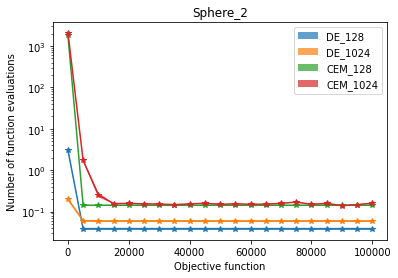

In [105]:
#Sphere - 2
tabulate_plot("Sphere",'2')

pop size,DE_mean,DE_std,CEM_mean,CEM_std,p_value
32,0.008450,0.001430,1.295890,0.710190,0.076368
64,0.007500,0.001520,0.662380,0.271930,0.141310
128,0.008080,0.001170,0.589330,0.165250,0.220947
256,0.007520,0.001790,0.516560,0.071480,0.323198
512,0.007250,0.001950,0.422230,0.039330,0.358925
1024,0.007640,0.001730,0.401600,0.056790,0.322674


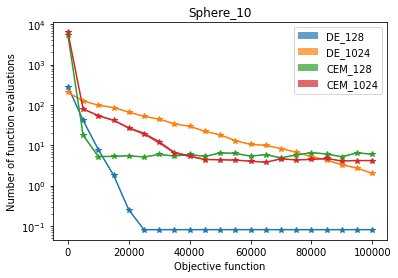

In [106]:
#Sphere - 10
tabulate_plot("Sphere",'10')

pop size,DE_mean,DE_std,CEM_mean,CEM_std,p_value
32,0.002670,0.002670,6.992470,4.236860,0.055321
64,0.003570,0.002310,8.724950,2.820940,0.189824
128,0.004810,0.002840,9.539460,3.748710,0.148821
256,0.004390,0.002610,7.674830,1.948490,0.235101
512,0.005410,0.002550,6.920140,1.980390,0.213632
1024,0.005750,0.002760,7.289370,2.051450,0.216750


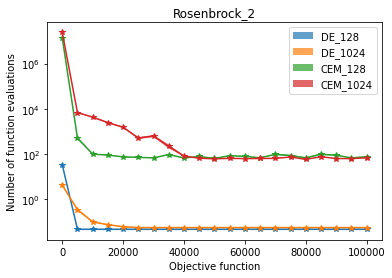

In [107]:
#Rosenbrock - 2
tabulate_plot("Rosenbrock",'2')

pop size,DE_mean,DE_std,CEM_mean,CEM_std,p_value
32,0.008370,0.000960,165.434390,130.915350,0.013299
64,0.008970,0.000670,105.965810,88.205790,0.008263
128,0.006970,0.001840,119.331590,71.334270,0.057925
256,0.007680,0.001430,100.670420,39.004450,0.151777
512,0.008690,0.001010,91.568520,26.214050,0.213323
1024,0.307180,0.053150,77.950720,24.277150,0.198138


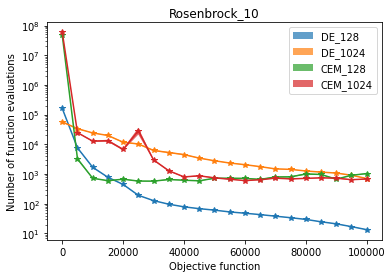

In [108]:
#Rosenbrock - 10
tabulate_plot("Rosenbrock",'10')

pop size,DE_mean,DE_std,CEM_mean,CEM_std,p_value
32,0.005360,0.002060,0.666410,0.175640,0.231120
64,0.006160,0.002840,1.188210,1.108450,0.001215
128,0.006240,0.001860,1.056280,0.918110,0.004906
256,0.007530,0.002710,1.029960,0.893950,0.005020
512,0.006080,0.002280,1.359030,1.001470,0.022340
1024,0.006390,0.001700,1.724970,2.310250,0.020477


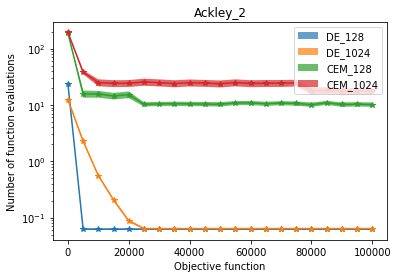

In [109]:
#Ackley - 2
tabulate_plot("Ackley",'2')

pop size,DE_mean,DE_std,CEM_mean,CEM_std,p_value
32,0.009340,0.000660,4.016090,0.615400,0.307114
64,0.009070,0.000840,3.956060,0.497300,0.327602
128,0.009390,0.000850,3.896460,0.546930,0.316695
256,0.008370,0.001070,3.772110,0.525760,0.317388
512,0.008780,0.001100,3.629430,0.572270,0.303910
1024,0.008620,0.000940,3.401420,0.628680,0.284110


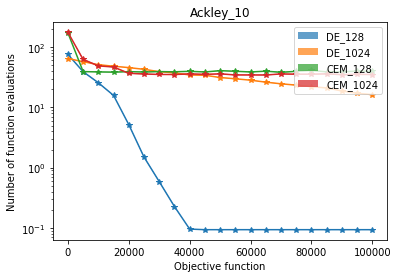

In [110]:
#Ackley - 10
tabulate_plot("Ackley",'10')

pop size,DE_mean,DE_std,CEM_mean,CEM_std,p_value
32,0.005380,0.003420,0.016650,0.005490,0.360197
64,0.002810,0.001670,0.015290,0.005710,0.228965
128,0.005240,0.002910,0.012650,0.001930,0.617126
256,0.005300,0.002320,0.014340,0.002660,0.517921
512,0.003970,0.002920,0.015720,0.004870,0.335718
1024,0.004540,0.002300,0.017090,0.004790,0.352071


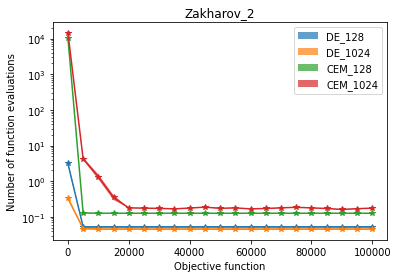

In [111]:
#Zakharov - 2
tabulate_plot("Zakharov",'2')

pop size,DE_mean,DE_std,CEM_mean,CEM_std,p_value
32,0.007700,0.000950,6164.778760,7750.630170,0.012740
64,0.009080,0.000530,1402.774860,935.998810,0.037601
128,0.008670,0.001380,1748.377080,926.896910,0.082753
256,0.007850,0.002040,1562.594090,510.366540,0.187640
512,0.008500,0.001450,1137.255490,424.551700,0.159778
1024,0.008950,0.000640,939.601470,292.295960,0.197353


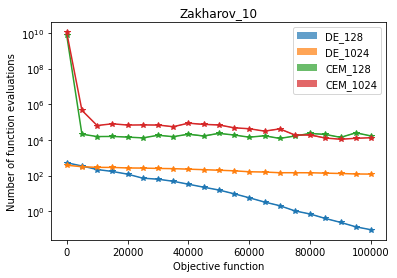

In [112]:
#Zakharov - 10
tabulate_plot("Zakharov",'10')

pop size,DE_mean,DE_std,CEM_mean,CEM_std,p_value
32,-0.976390,0.017310,0.558630,0.278160,0.224111
64,-0.988260,0.003450,0.484680,0.419610,0.197698
128,-0.989990,0.000000,0.373390,0.459110,0.208086
256,-0.989990,0.000000,0.392620,0.480900,0.201644
512,-0.989990,0.000000,0.282090,0.430980,0.231021
1024,-0.989990,0.000000,0.692160,0.453250,0.170945


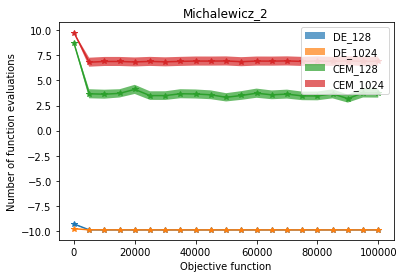

In [113]:
#Michalewicz - 2
tabulate_plot("Michalewicz",'2')

pop size,DE_mean,DE_std,CEM_mean,CEM_std,p_value
32,-8.926810,0.020130,2.320310,0.526720,0.326630
64,-8.731120,0.175450,2.748260,0.531200,0.326238
128,-8.258430,0.139140,2.963590,0.623370,0.311430
256,-7.967940,0.205060,3.247740,0.365090,0.319712
512,-7.428670,0.300920,3.632540,0.272930,0.320694
1024,-7.199330,0.398760,3.815990,0.390190,0.317499


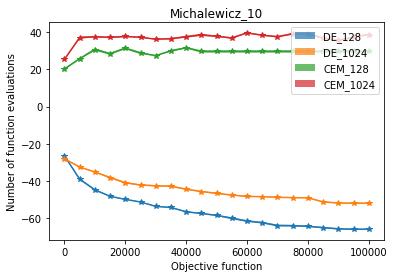

In [114]:
#Michalewicz - 10
tabulate_plot("Michalewicz",'10')

# Animation

In [196]:
!apt install imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texlive-base-bin transfig ufraw-batch inkscape libjxr-tools
  libwmf0.2-7-gtk poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fo

In [221]:
from numpy import arange
import matplotlib
from numpy import meshgrid
from matplotlib import pyplot
from numpy.random import seed
from numpy.random import rand
from matplotlib.animation import FuncAnimation
from IPython import display
from matplotlib import animation, rc
from IPython.display import HTML, Image
matplotlib.use('Agg')
rc('animation', html='html5')
def animate(func,method,dim,name):

  global to_plot
  to_plot,_ = deserialize(func,method,dim,'32')
  to_plot=to_plot[0]

  global optima_x
  if func =='Sphere':
    func = Sphere_f
    optima_x=[0.0,0.0]
  elif func == 'Rosenbrock':
    func = Rosenbrock_f
    optima_x=[1.0,1.0]
  elif func == 'Ackley':
    func = Ackley_f
    optima_x=[0.0,0.0]
  elif func == 'Zakharov':
    func = Zakharov_f
    optima_x=[0.0,0.0]
  elif func == 'Michalewicz':
    func= Michalewicz_f
    optima_x=[2.0,1.57]

    
  fig, ax = pyplot.subplots()

  def ax_plot(ax,func):
    r_min, r_max = -5.0, 5.0
    xaxis = arange(r_min, r_max, 0.1)
    yaxis = arange(r_min, r_max, 0.1)
    x, y = meshgrid(xaxis, yaxis)
    results = func([x,y])

    ax.contourf(x, y, results, levels=50, cmap='jet')
    global optima_x
    ax.plot([optima_x[0]], [optima_x[1]], '*', color='white')

  ax_plot(ax,func)

  def AnimationFunction(frame):
    global to_plot
    ax.clear()
    ax_plot(ax,func)
    sample_x = to_plot[frame][0][0]
    sample_y = to_plot[frame][0][1]
    ax.plot(sample_x, sample_y, 'o', color='red')

  

  anim_created = FuncAnimation(fig, AnimationFunction, frames=len(to_plot), interval=180)

  try:
    anim_created.save(name, writer='imagemagick', fps=180)
  except:
    video = anim_created.to_html5_video()
    html = display.HTML(video)
    display.display(html)
  
  plt.close()




In [211]:
animate("Sphere","DE",'2',"/content/Sphere_DE_2.gif")

In [212]:
animate("Sphere","CEM",'2',"/content/Sphere_CEM_2.gif")

In [ ]:
animate("Rosenbrock","DE",'2',"/content/Rosenbrock_DE_2.gif")

In [ ]:
animate("Rosenbrock","CEM",'2',"/content/Rosenbrock_CEM_2.gif")

In [222]:
animate("Ackley","DE",'2',"/content/Ackley_DE_2.gif")

In [ ]:
animate("Ackley","CEM",'2',"/content/Ackley_CEM_2.gif")

In [ ]:
animate("Zakharov","DE",'2',"/content/Zakharov_DE_2.gif")

In [225]:
animate("Zakharov","CEM",'2',"/content/Zakharov_CEM_2.gif")

In [ ]:
animate("Michalewicz","DE",'2',"/content/Michalewicz_DE_2.gif")

In [ ]:
animate("Michalewicz","CEM",'2',"/content/Michalewicz_CEM_2.gif")